<a href="https://colab.research.google.com/github/farazjawedd/Explainable-AI/blob/main/Copy_of_xAI_Assignment_5_Explainable_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AIPI 590
### Assignment 5: Explainable Deep Learning

#### Faraz Jawed - fj49

### Hypothesis:

*   **Null Hypothesis (H0):** There is no significant difference in the saliency patterns of a CNN model when classifying images of natural objects versus man-made objects in the CIFAR-10 dataset.

*   **Alternative Hypothesis (H1):** The CNN model shows significantly different saliency patterns when classifying images of natural objects compared to man-made objects in the CIFAR-10 dataset, suggesting it relies on different features for these two broad categories.

### Code Demonstration

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


100%|██████████| 170M/170M [00:02<00:00, 78.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Epoch 1, Loss: 1.6950927955043316
Epoch 2, Loss: 1.3329705037540198
Finished Training
Average saliency for natural objects: 0.6079
Average saliency for man-made objects: 0.7239
T-statistic: -63.85854476226622, p-value: 0.0


<ipython-input-8-ff0dc417a67c>:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([natural_saliency, man_made_saliency], labels=['Natural Objects', 'Man-made Objects'])


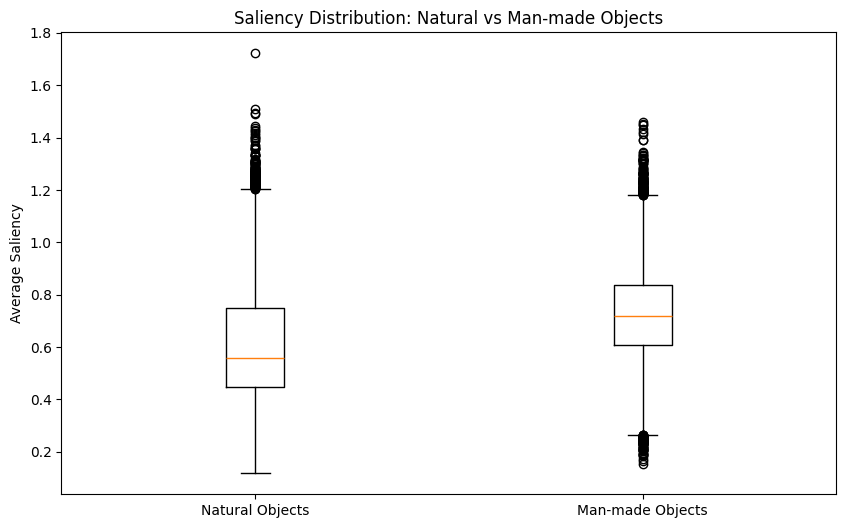

In [ ]:
# Loading CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# Define CNN model (took the architecture from gpt)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')

print('Finished Training')

# Function to compute saliency map
def get_saliency_map(image, label):
    image.requires_grad_()
    output = net(image.unsqueeze(0))
    output[0, label].backward()
    return image.grad.abs().sum(dim=1).squeeze()

# Analyze saliency patterns
natural_objects = [2, 3, 4, 5, 6, 7]  # bird, cat, deer, dog, frog, horse
man_made_objects = [0, 1, 8, 9]  # airplane, automobile, ship, truck

natural_saliency = []
man_made_saliency = []

for images, labels in trainloader:
    for image, label in zip(images, labels):
        saliency = get_saliency_map(image, label)
        if label.item() in natural_objects:
            natural_saliency.append(saliency.mean().item())
        elif label.item() in man_made_objects:
            man_made_saliency.append(saliency.mean().item())

# Analyze results
print(f"Average saliency for natural objects: {np.mean(natural_saliency):.4f}")
print(f"Average saliency for man-made objects: {np.mean(man_made_saliency):.4f}")

# Perform statistical test
from scipy import stats
t_stat, p_value = stats.ttest_ind(natural_saliency, man_made_saliency)
print(f"T-statistic: {t_stat}, p-value: {p_value}")

# Visualize results
plt.figure(figsize=(10, 6))
plt.boxplot([natural_saliency, man_made_saliency], labels=['Natural Objects', 'Man-made Objects'])
plt.title('Saliency Distribution: Natural vs Man-made Objects')
plt.ylabel('Average Saliency')
plt.show()


Based on the experimental results, the average saliency for man-made objects (0.7239) is significantly higher than that for natural objects (0.6079). The computed T-statistic of -63.8585 and corresponding p-value of 0.0 provide strong statistical evidence to reject the null hypothesis.

Therefore, we conclude that the CNN model exhibits significantly different saliency patterns when classifying natural objects compared to man-made objects within the CIFAR-10 dataset. This indicates that the model relies on different features or image regions to distinguish between these two categories.